In [27]:
# IMPORT NEEDED LIBRARIES 
import pandas as pd
import numpy as np
import warnings
import pmdarima as pm
import time
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from common.preprocessor import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [28]:
data = pd.read_csv('Modified Data.csv', parse_dates=True, index_col=[0])

In [29]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


In [30]:
data.describe()

,Price
count,252.00
mean,69.46
std,28.03
min,19.96
25%,48.47
50%,65.47
75%,91.95
max,134.79


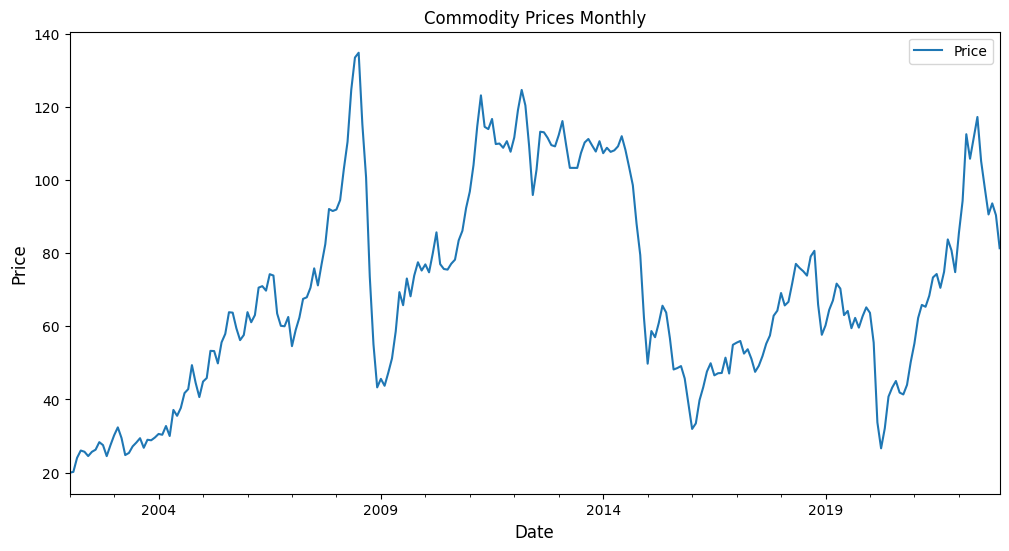

In [31]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

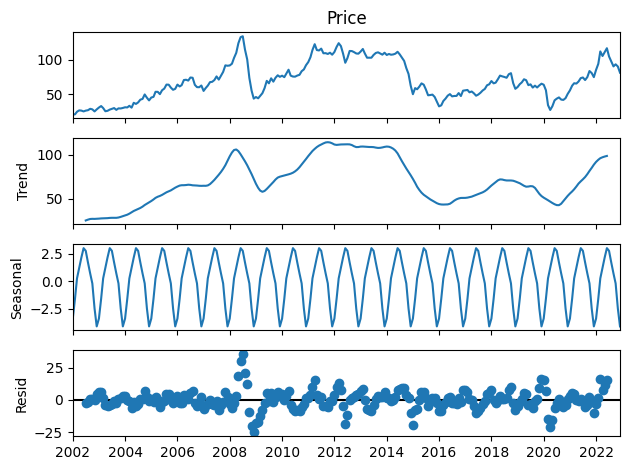

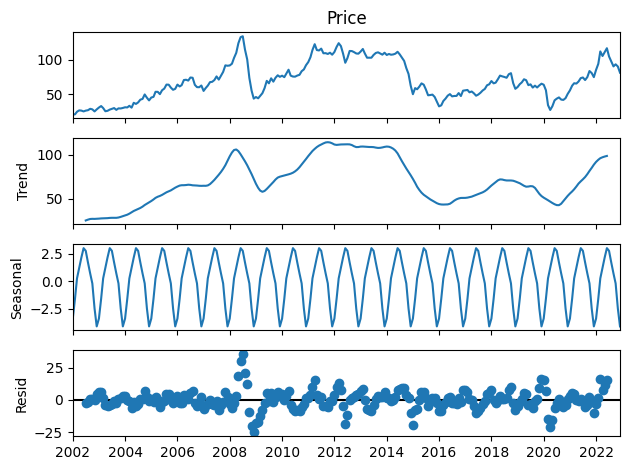

In [32]:
decomposition = seasonal_decompose(data["Price"], model="additive")  # "Price" is likely your column name for oil prices
decomposition.plot()  # Visualize the trend, seasonal component, and residuals

In [33]:
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

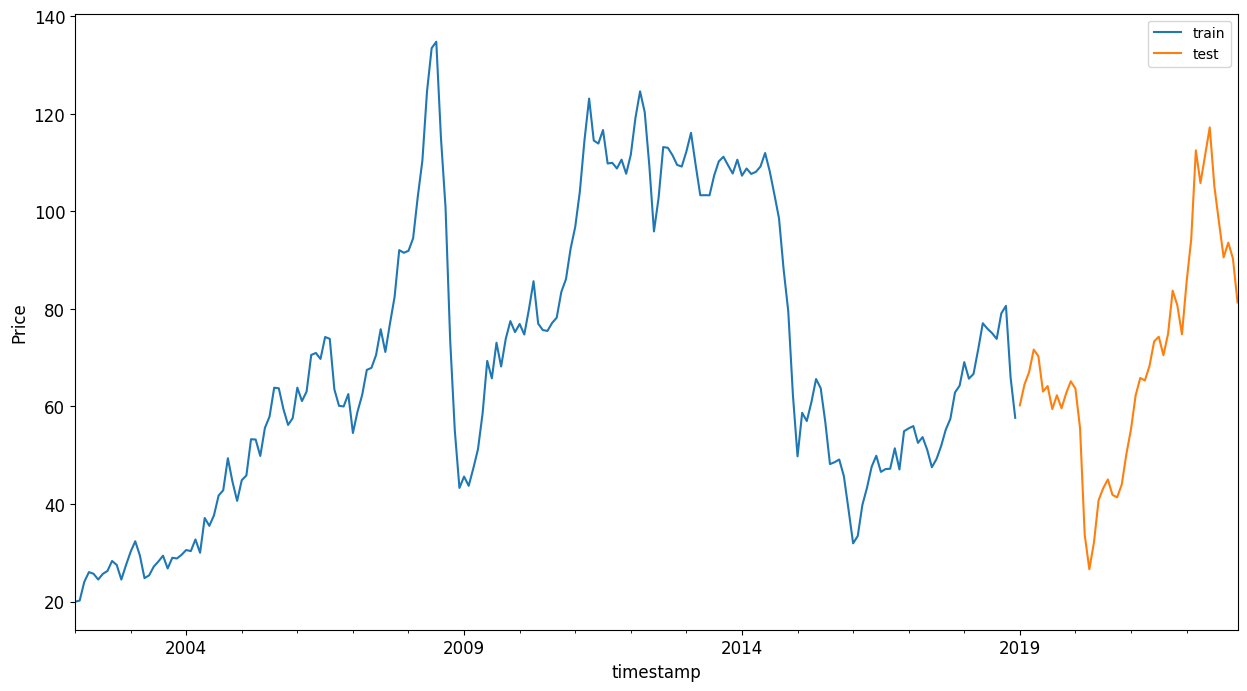

In [34]:
data[(data.index < test_start_date) & (data.index >= train_start_date)][['Price']].rename(columns={'Price':'train'}) \
    .join(data[test_start_date:][['Price']].rename(columns={'Price':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [35]:
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


In [36]:
# # Prepare data for training
# scaler = MinMaxScaler()
# train['Price'] = scaler.fit_transform(train)
# train.head(10)

In [37]:
# # visualize original vs scaled data
# data[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
# train.rename(columns={'Price':'scaled Price'}).plot.hist(bins=100, fontsize=12)
# plt.show()

In [38]:
# # scale test data
# test['Price'] = scaler.transform(test)
# test.head(10)

In [39]:
# Check for stationarity with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("Data may be non-stationary. Consider differencing.")

print("Testing stationarity of scaled training data:")
adf_test(train['Price'])

Testing stationarity of scaled training data:
ADF Statistic: -2.5026745232331122
p-value: 0.11482493982756942
Data may be non-stationary. Consider differencing.


In [40]:
# Identify number of differences required (if necessary)
n_diffs = pm.arima.ndiffs(train['Price'], test='adf')
print(f"\nNumber of differences required for scaled training data: {n_diffs}")



Number of differences required for scaled training data: 1


In [41]:
# Perform differencing if required
if n_diffs > 0:
    differenced_train = train.diff(n_diffs).dropna()
else:
    differenced_train = train.copy()

<Axes: >

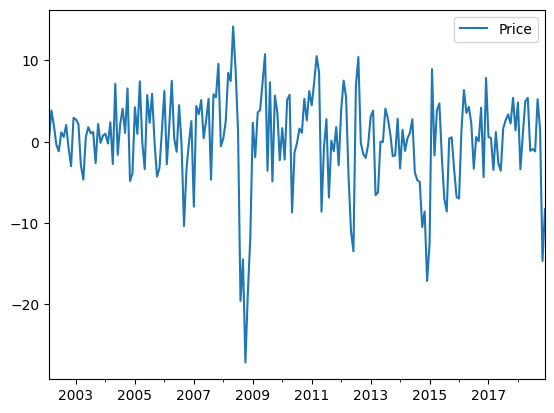

In [42]:
differenced_train.plot()

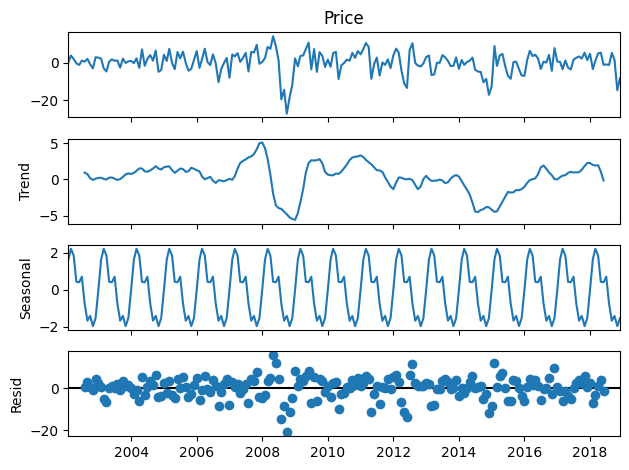

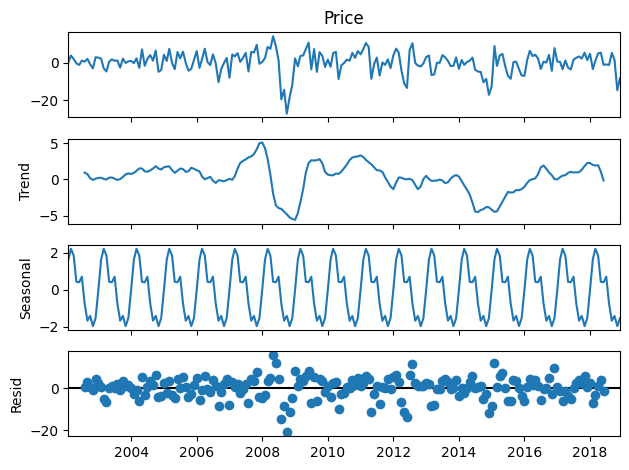

In [43]:
decomposition = seasonal_decompose(differenced_train["Price"], model="additive")  # "Price" is likely your column name for oil prices
decomposition.plot()  # Visualize the trend, seasonal component, and residuals


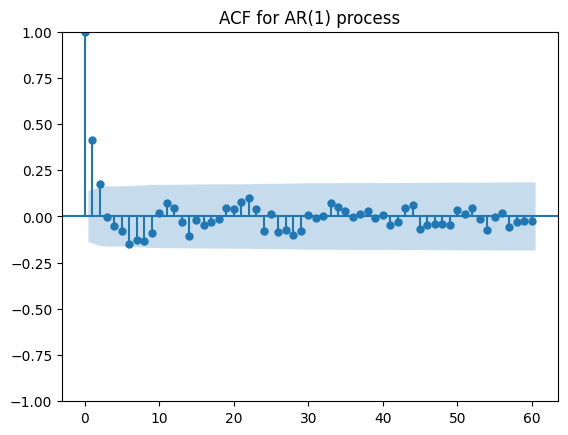

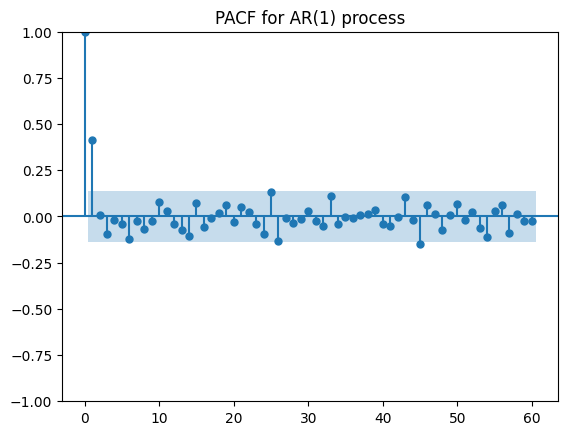

In [44]:
# ACF and PACF plots (optional) using lags of 48 (4 years)
plot_acf(differenced_train['Price'], lags=60, title='ACF for AR(1) process')
plt.show()
plot_pacf(differenced_train['Price'], lags=60, title='PACF for AR(1) process')
plt.show()

In [45]:
# df_2002 = data['2002']
# df_2003 = data['2003']
# df_2004 = data['2004']
# df_2005 = data['2005']
# df_2006 = data['2006']
# fig, axs = plt.subplots(5, figsize=(10, 18))

# # Plot for 2002
# axs[0].plot(df_2002.index, df_2002['Price'])
# axs[0].set_title('Price in 2002')
# axs[0].set_xlabel('Date')
# axs[0].set_ylabel('Price')

# # Plot for 2003
# axs[1].plot(df_2003.index, df_2003['Price'])
# axs[1].set_title('Price in 2003')
# axs[1].set_xlabel('Date')
# axs[1].set_ylabel('Price')

# # Plot for 2004
# axs[2].plot(df_2004.index, df_2004['Price'])
# axs[2].set_title('Price in 2004')
# axs[2].set_xlabel('Date')
# axs[2].set_ylabel('Price')

# # Plot for 2005
# axs[3].plot(df_2005.index, df_2005['Price'])
# axs[3].set_title('Price in 2005')
# axs[3].set_xlabel('Date')
# axs[3].set_ylabel('Price')

# # Plot for 2006
# axs[4].plot(df_2006.index, df_2006['Price'])
# axs[4].set_title('Price in 2006')
# axs[4].set_xlabel('Date')
# axs[4].set_ylabel('Price')

# plt.tight_layout()
# plt.show()

In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_2002 = data['2002']
df_2003 = data['2003']
df_2004 = data['2004']
df_2005 = data['2005']
df_2006 = data['2006']
# Create subplot figure
fig = make_subplots(rows=5, cols=1)

# Add traces
fig.add_trace(go.Scatter(x=df_2002.index, y=df_2002['Price'], name='Price in 2002'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_2003.index, y=df_2003['Price'], name='Price in 2003'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_2004.index, y=df_2004['Price'], name='Price in 2004'), row=3, col=1)
fig.add_trace(go.Scatter(x=df_2005.index, y=df_2005['Price'], name='Price in 2005'), row=4, col=1)
fig.add_trace(go.Scatter(x=df_2006.index, y=df_2006['Price'], name='Price in 2006'), row=5, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_xaxes(title_text="Date", row=5, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="Price", row=3, col=1)
fig.update_yaxes(title_text="Price", row=4, col=1)
fig.update_yaxes(title_text="Price", row=5, col=1)

# Update layout
fig.update_layout(height=1000, width=1000, title_text="Price from 2002 to 2006")

fig.show()

In [47]:
# Check for stationarity with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("Data may be non-stationary. Consider differencing.")

print("Testing stationarity of scaled training data:")
adf_test(differenced_train['Price'])

Testing stationarity of scaled training data:
ADF Statistic: -9.015794676260294
p-value: 5.9556970044840115e-15
Data is likely stationary.


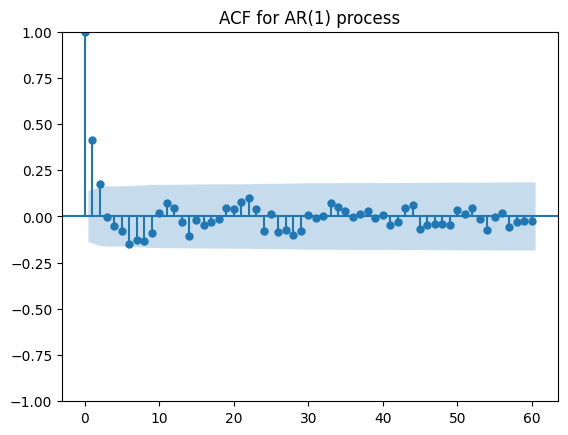

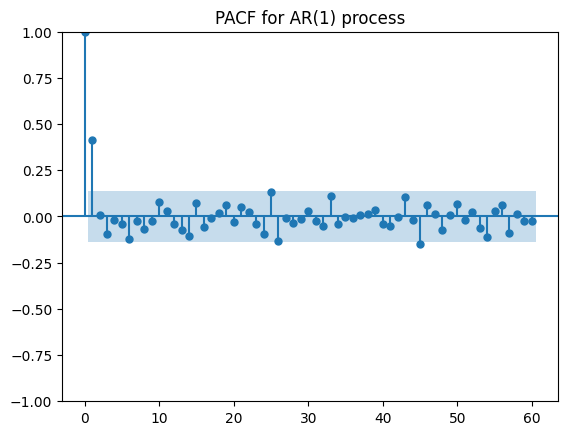

In [48]:
# ACF and PACF plots (optional)
plot_acf(differenced_train['Price'], lags=60, title='ACF for AR(1) process')
plt.show()
plot_pacf(differenced_train['Price'], lags=60, title='PACF for AR(1) process')
plt.show()

In [49]:
# Use auto_arima to find best parameters
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True)
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1342.381, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1281.283, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1340.404, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1308.779, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1255.622, Time=1.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1288.130, Time=1.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1257.341, Time=1.47 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1257.435, Time=1.61 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1263.110, Time=1.77 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1258.579, Time=3.06 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [50]:
# other information criteria
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True, information_criterion='bic')
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=1348.885, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=1294.292, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=1343.656, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=1318.536, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=1271.883, Time=1.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=3.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : BIC=1301.140, Time=1.11 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : BIC=1276.854, Time=1.70 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : BIC=1276.949, Time=2.51 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : BIC=1279.372, Time=1.58 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : BIC=1281.345, Time=3.46 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [51]:
# other information criteria
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True, information_criterion='hqic')
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")
# decide tradeoff between time and aic

Performing stepwise search to minimize hqic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : HQIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : HQIC=1345.015, Time=0.31 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : HQIC=1286.552, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : HQIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : HQIC=1341.721, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : HQIC=1312.731, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : HQIC=1262.208, Time=1.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : HQIC=inf, Time=2.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : HQIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : HQIC=1293.400, Time=1.15 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : HQIC=1265.244, Time=1.45 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : HQIC=1265.339, Time=1.57 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : HQIC=1269.697, Time=1.12 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : HQIC=1267.800, Time=3.19 sec
 ARIMA(1,0,0)(2,1,0)[12]

In [52]:
print(f'model order: {model.order}, \nmodel seasonal order: {model.seasonal_order}')

model order: (1, 0, 0), 
model seasonal order: (2, 1, 0, 12)


In [69]:
# Fit the SARIMA model on the differenced training data
model = SARIMAX(endog=differenced_train, order=model.order, seasonal_order=model.seasonal_order, freq="MS")
results = model.fit(disp=0)  # Suppress convergence output
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  203
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -622.817
Date:                            Thu, 21 Mar 2024   AIC                           1253.635
Time:                                    00:42:46   BIC                           1266.644
Sample:                                02-01-2002   HQIC                          1258.904
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.056      7.335      0.000       0.300       0.520
ar.S.L12      -0.5252      0.058   

In [70]:
test.shape

(48, 1)

In [71]:
HORIZON = 3
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['Price+'+str(t)] = test_shifted['Price'].shift(-t, freq='MS')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,Price,Price+1,Price+2,Price+3
2019-01-01,60.23,64.50,67.05,71.66
2019-02-01,64.50,67.05,71.66,70.30
2019-03-01,67.05,71.66,70.30,63.05
2019-04-01,71.66,70.30,63.05,64.19
2019-05-01,70.30,63.05,64.19,59.47


In [72]:
model.order

(1, 0, 0)

In [73]:
model.seasonal_order

(2, 1, 0, 12)

In [75]:
train_ts.shape

(204,)

In [76]:
%%time
training_window = 20
# dedicate 30 days (720 hours) for training

train_ts = train['Price']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = model.order
seasonal_order = model.seasonal_order

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)


2019-01-01 00:00:00
1 : predicted = [58.84 51.81 49.15] expected = [60.23, 64.5, 67.05, 71.66]
2019-02-01 00:00:00
2 : predicted = [53.17 50.49 51.81] expected = [64.5, 67.05, 71.66, 70.3]
2019-03-01 00:00:00
3 : predicted = [62.2  63.92 66.03] expected = [67.05, 71.66, 70.3, 63.05]
2019-04-01 00:00:00
4 : predicted = [70.15 73.6  70.45] expected = [71.66, 70.3, 63.05, 64.19]
2019-05-01 00:00:00
5 : predicted = [75.93 73.64 71.44] expected = [70.3, 63.05, 64.19, 59.47]
2019-06-01 00:00:00
6 : predicted = [69.45 67.48 63.66] expected = [63.05, 64.19, 59.47, 62.29]
2019-07-01 00:00:00
7 : predicted = [66.29 67.78 74.69] expected = [64.19, 59.47, 62.29, 59.63]
2019-08-01 00:00:00
8 : predicted = [64.58 71.   73.35] expected = [59.47, 62.29, 59.63, 62.71]
2019-09-01 00:00:00
9 : predicted = [66.42 69.34 55.74] expected = [62.29, 59.63, 62.71, 65.17]
2019-10-01 00:00:00
10 : predicted = [64.69 50.89 43.47] expected = [59.63, 62.71, 65.17, 63.67]
2019-11-01 00:00:00
11 : predicted = [45.82 3

In [77]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(predictions)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='Month')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

ValueError: Length of values (43) does not match length of index (45)